In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

In [3]:
# load dataset
dataset = pd.read_csv('BitstampData_sample.csv')

In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# shape
dataset.shape

(499999, 8)

In [6]:
# peek at data
set_option('display.width', 100)
dataset.tail(2)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
499997,1355317740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499998,1355317800,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# describe data
set_option('precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,5.000e+05,24521.000,24521.000,24521.000,24521.000,24521.000,24521.000,24521.000
mean,1.340e+09,9.822,9.825,9.818,9.821,21.022,206.749,9.822
std,8.660e+06,2.666,2.667,2.665,2.666,55.478,547.135,2.666
min,1.325e+09,3.800,3.800,3.800,3.800,0.000,0.000,3.800
25%,1.333e+09,7.200,7.200,7.200,7.200,2.170,21.020,7.200
50%,1.340e+09,10.800,10.800,10.790,10.790,7.340,67.920,10.793
75%,1.348e+09,11.840,11.840,11.830,11.840,20.240,199.280,11.833
max,1.355e+09,16.410,16.410,15.490,16.000,2958.478,31212.195,16.387


In [8]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [9]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [10]:
dataset=dataset.drop(columns=['Timestamp'])

In [11]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [12]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
499994,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.343,0.0
499995,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0
499996,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0
499997,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0
499998,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0


In [13]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [14]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
499994,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.343,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499995,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499996,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499997,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499998,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.379


In [15]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
499994,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.343,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499995,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499996,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.342,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499997,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.380
499998,13.34,13.34,13.34,13.34,3.9,52.026,13.34,13.34,13.341,0.0,...,44.067,NaN,NaN,NaN,NaN,10.0,10.0,13.34,13.34,13.379


In [16]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [17]:
dataset = dataset.dropna(axis=0)

In [18]:
dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
499965,13.34,3.9,13.34,0.0,13.351,13.356,13.386,0.075,-0.299,0.01,...,44.067,11.111,1.111e+01,11.111,11.111,10.0,10.0,13.362,13.345,13.388
499966,13.34,3.9,13.34,0.0,13.349,13.355,13.386,0.075,-0.224,0.01,...,44.067,11.111,1.111e+01,11.111,11.111,10.0,10.0,13.363,13.343,13.387
499967,13.34,3.9,13.34,0.0,13.348,13.354,13.385,-0.596,-0.075,0.01,...,44.067,0.000,7.407e+00,11.111,11.111,10.0,10.0,13.364,13.342,13.387
499968,13.34,3.9,13.34,0.0,13.346,13.353,13.385,-0.596,0.000,-0.08,...,44.067,0.000,3.704e+00,11.111,11.111,10.0,10.0,13.356,13.342,13.387
499969,13.34,3.9,13.34,0.0,13.345,13.352,13.385,-0.596,0.075,-0.08,...,44.067,0.000,2.842e-14,11.111,11.111,10.0,10.0,13.348,13.342,13.387


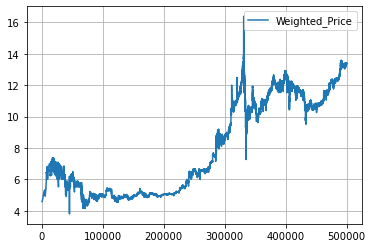

In [19]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

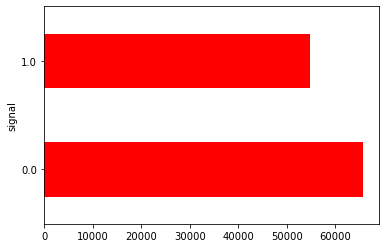

In [20]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

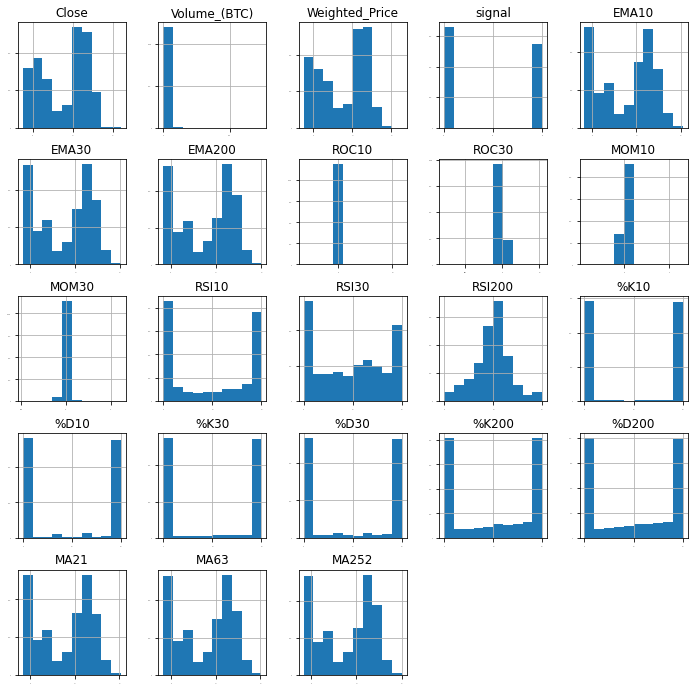

In [21]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

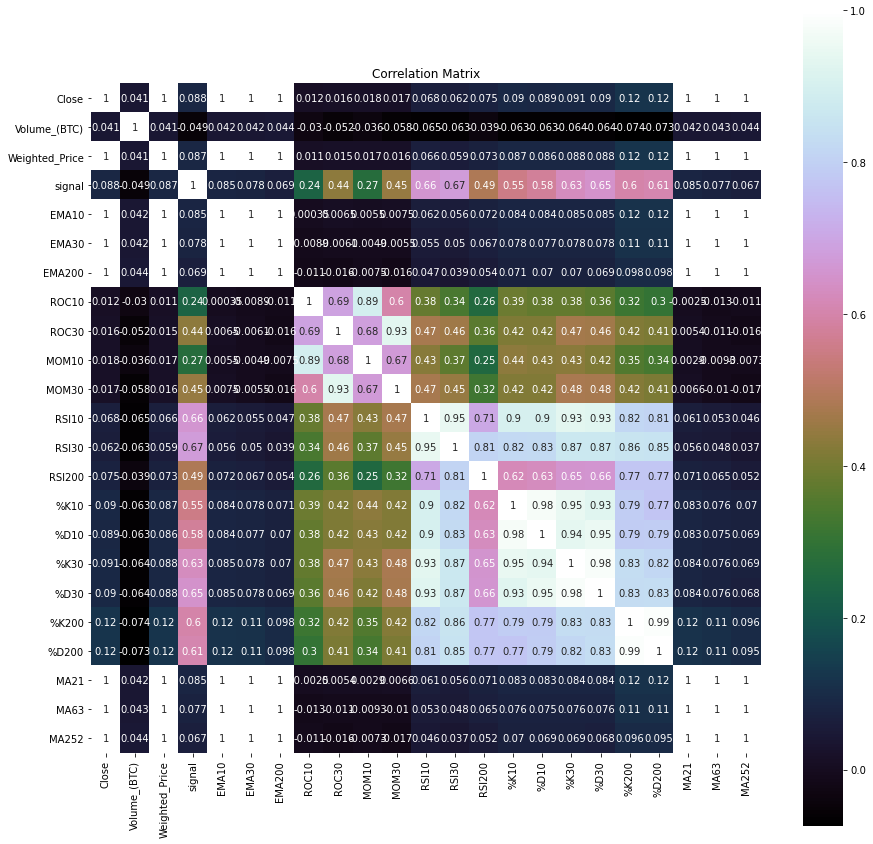

In [22]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [23]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [28]:
# test options for classification
num_folds = 10
#seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [29]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [31]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.864787 (0.004353)
LDA: 0.872650 (0.005893)
KNN: 0.904487 (0.003413)
CART: 0.933388 (0.002618)
NB: 0.809100 (0.004879)
NN: 0.888362 (0.007772)
AB: 0.867250 (0.005117)
GBM: 0.891625 (0.004233)
RF: 0.941275 (0.002173)


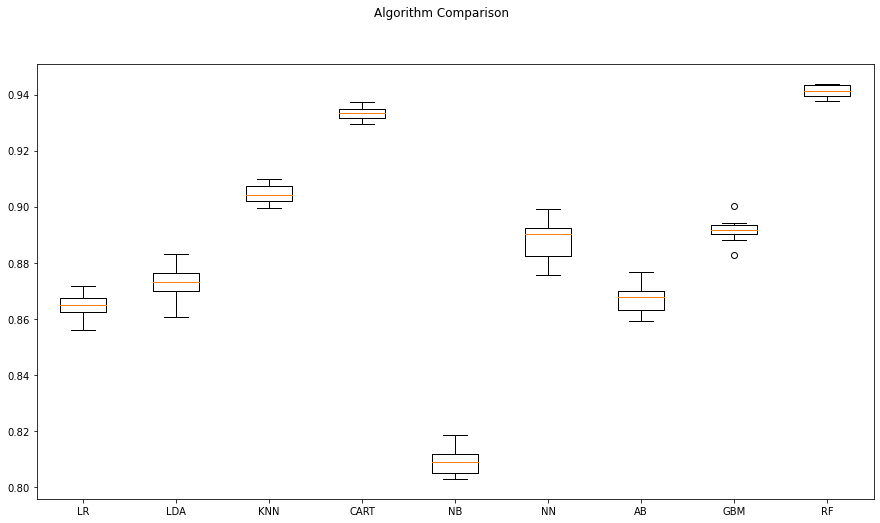

In [32]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [34]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.911813 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#5 0.871925 (0.002962) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.871713 (0.004221) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#2 0.910775 (0.003988) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.911813 (0.003690) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.868500 (0.006199) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#7 0.871175 (0.004589) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.906200 (0.003116) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#3 0.908500 (0.003690) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [35]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10)
#model = LogisticRegression()
model.fit(X_train, Y_train)
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))

0.91665


Text(0.5, 0, 'Variable Importance')

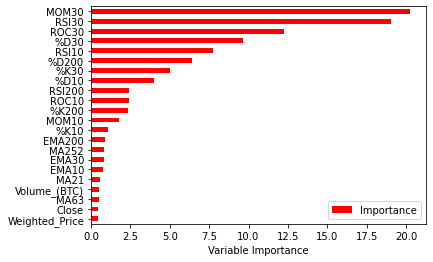

In [36]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100},\
index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', \
color='r' )
plt.xlabel('Variable Importance')

<AxesSubplot:>

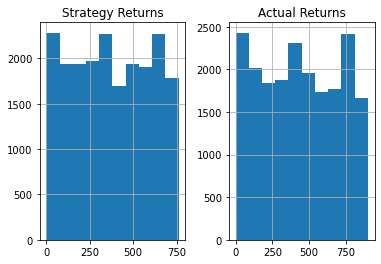

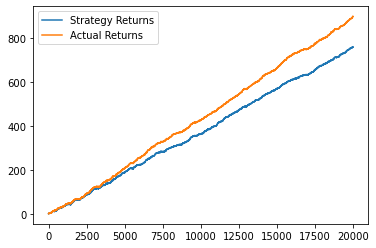

In [37]:
backtestdata = pd.DataFrame(index=X_validation.index)
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] *\
backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * \
backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()